In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image  
import time

import torchvision
import torchvision.transforms as transforms
import torchvision.utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from utils import toumap, totsne, plotsmart
from utils import getallranks, calcmap
from utils import bestk_silhouette_score, getclusters_ws

from dataset import CustomDataset, DatasetFeatsTrain, dsbuild
from model import netmodel
from loss import HybridLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

print('Using device:', torch.cuda.is_available(), torch.cuda.get_device_name(1))

Using device: True NVIDIA RTX A4500


In [2]:
device = torch.device("cuda:1")  # Seleciona a segunda GPU

# Feature Extraction

**Pre-traineded models**

In [3]:
from timm import create_model
import timm

# timm.list_models("*convnex*", pretrained=True)
netfeat = create_model("convnext_xxlarge.clip_laion2b_soup_ft_in12k", pretrained=True).to(device)
netfeat.head.fc = torch.nn.Identity()
netfeat.to(device)
netfeat.eval()

def getfeat(x):
    with torch.no_grad():
        X = netfeat(x)
    return X   

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 16994a20-5d63-4463-965d-b82c96ed37be)')' thrown while requesting HEAD https://huggingface.co/timm/convnext_xxlarge.clip_laion2b_soup_ft_in12k/resolve/main/model.safetensors


In [5]:
class ConvertTo3Channels:
    def __call__(self, img):
        # Se a imagem já tiver 3 canais, retorne-a como está
        if img.mode == "RGB":
            return img
        # Caso contrário, converta-a para RGB
        return img.convert("RGB")
    
transform = transforms.Compose(
    [
        ConvertTo3Channels(),
        transforms.Resize((224, 224), transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]
)

def configfeats(ds):
    with torch.no_grad():
        ds.feats = [[getfeat(d.unsqueeze(0).to(device))[0].cpu(), l] for d, l in ds]

ds = torchvision.datasets.MNIST('~/lab/ds',train = True, transform=transform, download=True)
dstest = torchvision.datasets.MNIST('~/lab/ds',train = False, transform=transform, download=True)

configfeats(ds)
configfeats(dstest)
len(ds.data)


60000

# Clustering and centroid computation

In [ ]:
#xtsne = totsne([f for f, l in ds.feats])
# plotsmart(xtsne, [l for _, l in ds.feats])

**Clustering step**

K score 3 : 0.33639187
K score 4 : 0.37919492
K score 5 : 0.4264476
K score 6 : 0.46394378
K score 7 : 0.47123763
K score 8 : 0.50776434
K score 9 : 0.5322019
K score 10 : 0.5738602
K score 11 : 0.5604369
K score 12 : 0.5609309
K score 13 : 0.5471681
K score 14 : 0.51204836
K score 15 : 0.49166462
K score 16 : 0.47278374
K score 17 : 0.45002759
K score 18 : 0.45165277
K score 19 : 0.43593335
K score 20 : 0.44385555
K score 21 : 0.42271125
K score 22 : 0.43018556
K score 23 : 0.42193192
K score 24 : 0.39984655
K score 25 : 0.40664026
K score 26 : 0.40516508
K score 27 : 0.40403327
K score 28 : 0.3944526
K score 29 : 0.38957864


/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


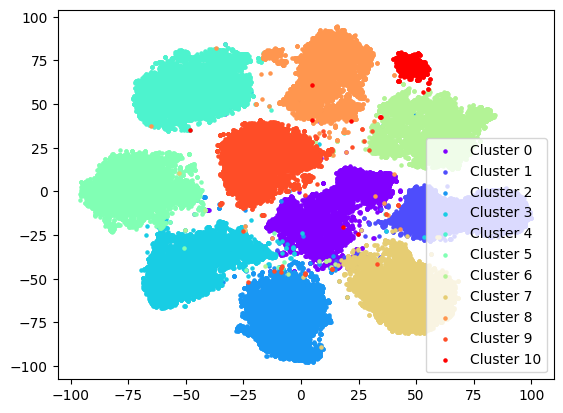

In [6]:
from sklearn.cluster import  AgglomerativeClustering

feats = [f for f,_ in ds.feats]
X = totsne(feats)

sampling_factor = 0.2 # for fast silhouette_score
idxs_sampling = random.sample(range(len(ds.feats)), round(len(ds.feats) * sampling_factor))
xsampling = totsne([feats[i] for i in idxs_sampling])
nclusters = bestk_silhouette_score(xsampling, rangeend=30) #get_nclusters(feats)

agg = AgglomerativeClustering(n_clusters=nclusters)
clusterlbs = agg.fit_predict(toumap(feats))
plotsmart(X, clusterlbs)

# Teacher neural network model

In [7]:
def getpar(ds):
    idxa = random.randint(0, len(ds.feats)-1)
    anchor, cl = ds.feats[idxa]

    is_same_class = random.choice([True, False])
    if is_same_class:
        pairidx = random.choice(ds.lbclassrel[cl.item()])
    else:
        cls = ds.idclasses.copy()
        cls.remove(cl.item())
        pairidx = random.choice(ds.lbclassrel[random.choice(cls)])
        
    pair_img, clp = ds.feats[pairidx]
    #print(cl, clp)
    mgadd = torch.tensor(ds.clusters_ws[cl.item()][clp.item()])
    return anchor, pair_img, torch.tensor(int(not is_same_class)), cl, clp, mgadd

def getbatch(ds, nbatch=32):
    ret = [getpar(ds) for n in range(nbatch)]
    anchors, pars, lbs, albs, plbs, mgs = [], [], [], [], [], []
    for r in ret:
        anchors.append(r[0])
        pars.append(r[1])
        lbs.append(r[2])
        albs.append(r[3])
        plbs.append(r[4])
        mgs.append(r[5])
    # [r[0] for r in ret], [r[1] for r in ret],[r[2] for r in ret]
    return torch.stack(anchors, dim=0), torch.stack(pars, dim=0), torch.stack(lbs, dim=0), torch.stack(albs, dim=0), torch.stack(plbs, dim=0), torch.stack(mgs, dim=0)

In [8]:

class histloss():
    def __init__(self) -> None:
        self.histloss =[]

hloss = histloss()

def treino(model, ds, n_epochs=1000, _margin = 2.0, _batchsize = 128):

    optimizer = optim.AdamW(model.parameters(), lr=0.0014)
    criterion = HybridLoss(margin=_margin)  # ContrastiveLoss(margin=_margin) 

    model.train()
    lossacum = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        ctd = 0
        start = time.time()

        img1, img2, label, lbs1, lbs2, mgadd = getbatch(ds, _batchsize)
        img1, img2, label, lbs1, lbs2, mgadd = img1.to(device), img2.to(device), label.to(device), lbs1.to(device), lbs2.to(device), mgadd.to(device) 
        optimizer.zero_grad()
        
        #img1, img2 = F.normalize(img1, dim=1), F.normalize(img2, dim=1)
        #print(img1.shape)
        _, outlbs1, ored1 = model(img1)     
        _, outlbs2, ored2 = model(img2)

        outlbs = F.log_softmax(torch.cat([outlbs1, outlbs2]), dim=0)
        rotulos = torch.cat([lbs1, lbs2])

        perda_instantanea = criterion(label, outlbs, rotulos, ored1, ored2, mgadd)  
        #perda_instantanea = criteriosmax(outlbs, rotulos) 
        perda_instantanea.backward()
        optimizer.step()

        running_loss += perda_instantanea.item() # loss_contrastive.item()
        lossacum += running_loss                 
        ctd+=1

        if epoch> 0 :  # print every 10 mini-batches
            print('[%d] loss: %.5f' %
                    (epoch + 1, running_loss / ctd), 'time: ' + str(time.time() - start))
            hloss.histloss.append(running_loss / ctd)
            running_loss = 0.0
            ctd = 0

    print('Finished Training')
    ds.training = False
    return n_epochs, lossacum

In [9]:
import time

dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

for idc in dstrain.clusters_ws:
    for idr in dstrain.clusters_ws[idc]:
        dstrain.clusters_ws[idc][idr] = 0

net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.79248 time: 0.5116567611694336
[3] loss: 0.61405 time: 0.5049014091491699
[4] loss: 0.36699 time: 0.4998641014099121
[5] loss: 0.34218 time: 0.5014195442199707
[6] loss: 0.30981 time: 0.508864164352417
[7] loss: 0.30787 time: 0.5069234371185303
[8] loss: 0.28353 time: 0.5024063587188721
[9] loss: 0.29154 time: 0.5094585418701172
[10] loss: 0.26910 time: 0.5059771537780762
[11] loss: 0.27373 time: 0.5031440258026123
[12] loss: 0.26042 time: 0.5026733875274658
[13] loss: 0.25790 time: 0.5111076831817627
[14] loss: 0.25100 time: 0.5040929317474365
[15] loss: 0.23644 time: 0.5039703845977783
[16] loss: 0.23314 time: 0.5119071006774902
[17] loss: 0.23135 time: 0.5069787502288818
[18] loss: 0.23329 time: 0.5045325756072998
[19] loss: 0.22721 time: 0.5062689781188965
[20] loss: 0.22484 time: 0.5103144645690918
[21] loss: 0.21742 time: 0.5123584270477295
[22] loss: 0.20987 time: 0.5052683353424072
[23] loss: 0.21144 time: 0.5066087245941162
[24] loss: 0.21811 time: 0.50728297233581

(1000, 56.05116631556302)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


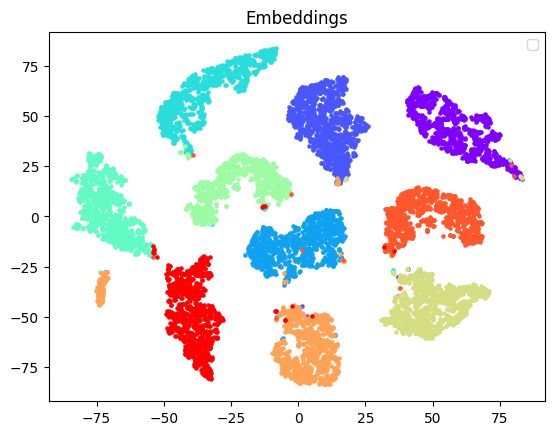

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


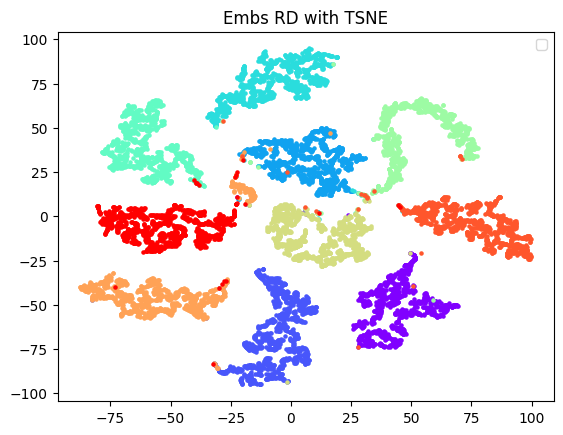

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


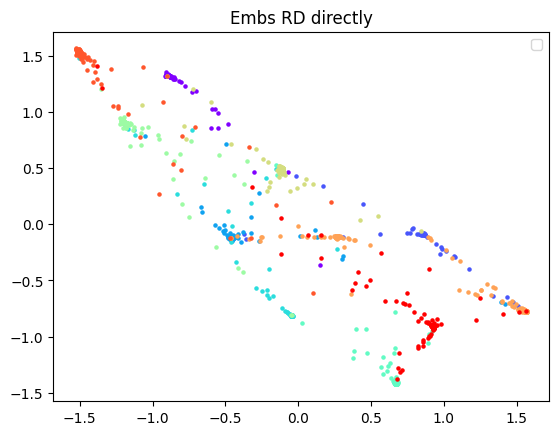

In [10]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [11]:
res = {}

In [12]:
# print()
print("Método proposto sem margem moderada")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_not_mg'] = resmap
resmap

Método proposto sem margem moderada


0.958541345953524

In [13]:
dstrain = DatasetFeatsTrain([ [f, torch.tensor(l)] for f,l in zip([f for f,_ in ds.feats], clusterlbs)], list(set([l.item() for l in clusterlbs])))
dstrain.clusters_ws = getclusters_ws(feats, clusterlbs)

hloss = histloss()
net = netmodel(out_dim=len(dstrain.idclasses), in_dim=3072).to(device)

treino(net, dstrain, 1000, _margin=0.5, _batchsize = 2048)

[2] loss: 0.87769 time: 0.5414202213287354
[3] loss: 0.61748 time: 0.5422184467315674
[4] loss: 0.47169 time: 0.5432648658752441
[5] loss: 0.38212 time: 0.542687177658081
[6] loss: 0.33805 time: 0.5437157154083252
[7] loss: 0.32364 time: 0.543140172958374
[8] loss: 0.31243 time: 0.5442466735839844
[9] loss: 0.30006 time: 0.5453732013702393
[10] loss: 0.28933 time: 0.5434494018554688
[11] loss: 0.28442 time: 0.5455224514007568
[12] loss: 0.27304 time: 0.5441319942474365
[13] loss: 0.27173 time: 0.5436913967132568
[14] loss: 0.26309 time: 0.5443458557128906
[15] loss: 0.24956 time: 0.5364549160003662
[16] loss: 0.24525 time: 0.5460090637207031
[17] loss: 0.23867 time: 0.5439836978912354
[18] loss: 0.24235 time: 0.5461044311523438
[19] loss: 0.23443 time: 0.5482778549194336
[20] loss: 0.22944 time: 0.5481631755828857
[21] loss: 0.23347 time: 0.5493943691253662
[22] loss: 0.21915 time: 0.548738956451416
[23] loss: 0.21154 time: 0.5505557060241699
[24] loss: 0.21263 time: 0.5489392280578613

(1000, 58.89862439485715)

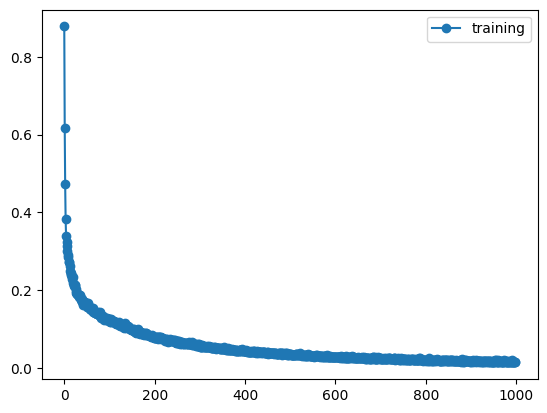

In [14]:
plt.plot(hloss.histloss, 'o-', label='training')
plt.legend()
plt.show()

#validafeats(net, device, [ f for f, _ in ds.feats], [ l for _, l in ds.feats])
#validafeats(net, device, [f for f, _ in dstest.feats], [ l for _, l in dstest.feats])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


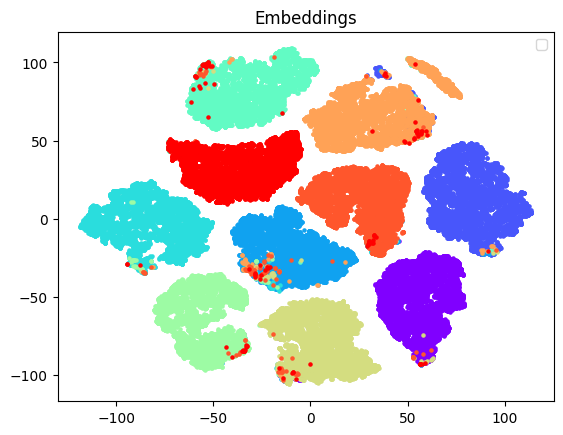

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


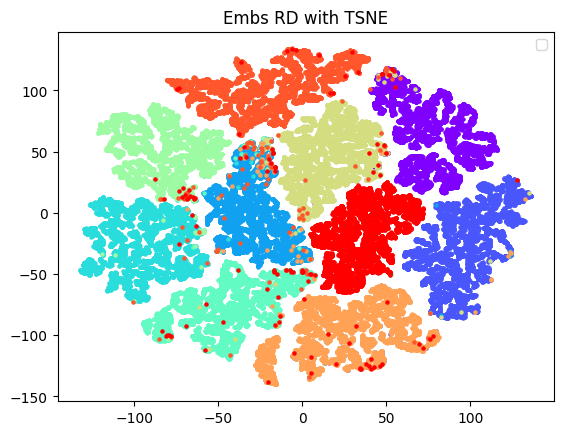

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


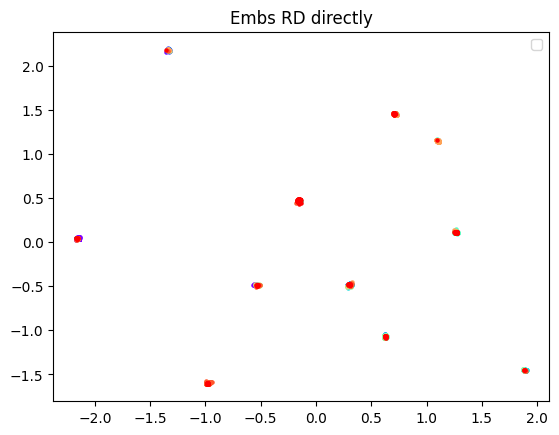

In [16]:
net.eval()
with torch.no_grad():
    trainfs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in ds.feats], [l for f,l in ds.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
trainfsembs, trainfsreduc = [f[0].cpu().squeeze() for f in trainfs], [f[2].cpu().squeeze() for f in trainfs]

plotsmart(totsne(trainfsembs), lbs, "Embeddings", True)
plotsmart(totsne(trainfsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(trainfsreduc), lbs, "Embs RD directly", True)

**TEST Set**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


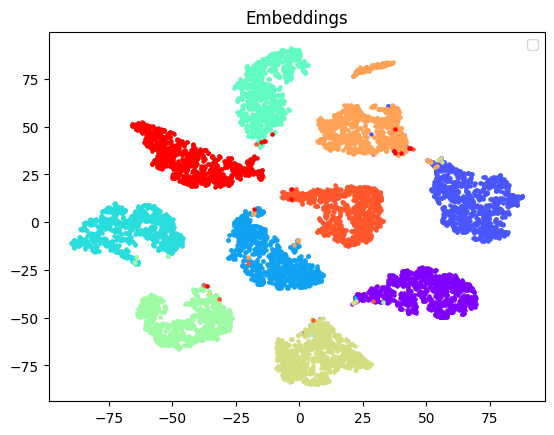

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


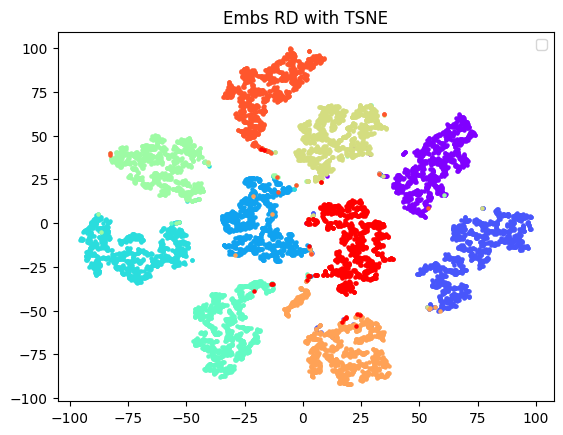

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


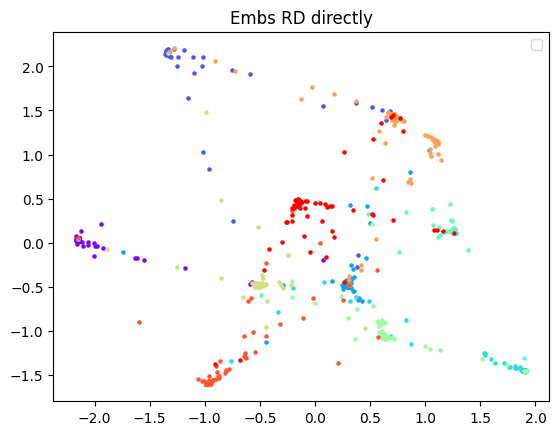

In [17]:
net.eval()
with torch.no_grad():
    fs, lbs = [net(f.to(device).unsqueeze(0)) for f,l in dstest.feats], [l for f,l in dstest.feats]
#.cpu().squeeze()
#plotsmart(totsne( fs), lbs, "", True)
fsembs, fsreduc = [f[0].cpu().squeeze() for f in fs], [f[2].cpu().squeeze() for f in fs]

plotsmart(totsne(fsembs), lbs, "Embeddings", True)
plotsmart(totsne(fsreduc), lbs, "Embs RD with TSNE", True)
plotsmart(np.array(fsreduc), lbs, "Embs RD directly", True)

In [18]:
# print()
print("Método proposto")
ranks = getallranks(fsreduc)
resmap = calcmap(ranks, lbs)
res['ours_with_mg'] = resmap
resmap

Método proposto


0.9789069090949444

In [19]:
print("Método proposto High Dim")
ranks = getallranks(fsembs)
resmap = calcmap(ranks, lbs)
res['ours_with_mg_highdim'] = resmap
resmap

Método proposto High Dim


0.9702077649823705

In [20]:
print("Sem projeção")
X = [f for f,l in dstest.feats]
ranks = getallranks(X)
resmap = calcmap(ranks, lbs)
res['no_projection'] = resmap
resmap

Sem projeção


0.7372925877516368

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

print("PCA")
X = [f for f,l in dstest.feats]
X_pca = pca.fit_transform(X)
ranks = getallranks(torch.tensor(X_pca))
resmap = calcmap(ranks, lbs)
res['pca'] = resmap
resmap

PCA


0.46566733583702746

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


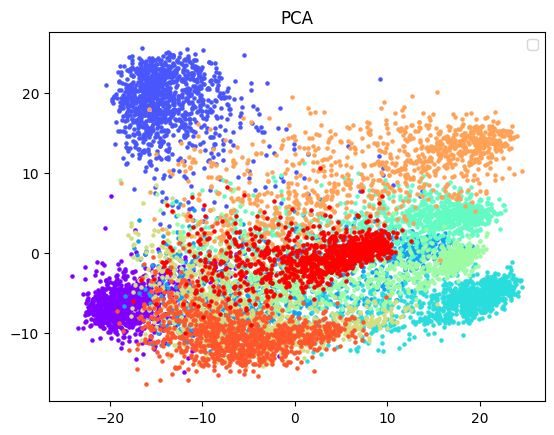

In [22]:
plotsmart(X_pca, lbs, "PCA", True)

In [23]:
print("T-SNE")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(totsne(X)))
resmap = calcmap(ranks, lbs)
res['tsne'] = resmap
resmap

T-SNE


0.9108959774076225

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


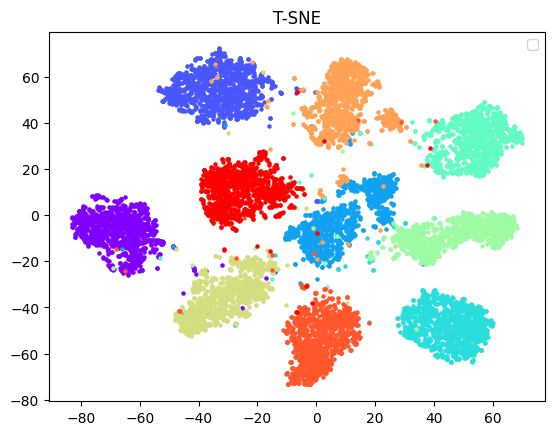

In [28]:
plotsmart(totsne(X), lbs, "T-SNE", True)

In [25]:
print("UMAP")
X = [f for f,l in dstest.feats]
ranks = getallranks(torch.tensor(toumap(X)))
resmap = calcmap(ranks, lbs)
res['umap'] = resmap
resmap

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP


0.9570576822074434

/home/de/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


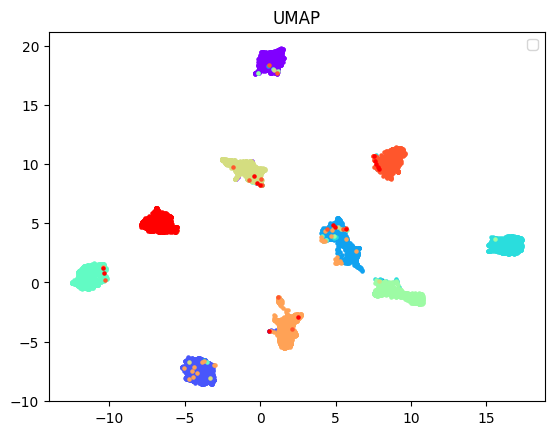

In [26]:
plotsmart(toumap(X), lbs, "UMAP", True)

In [27]:
res

{'ours_not_mg': 0.958541345953524,
 'ours_with_mg': 0.9789069090949444,
 'ours_with_mg_highdim': 0.9702077649823705,
 'no_projection': 0.7372925877516368,
 'pca': 0.46566733583702746,
 'tsne': 0.9108959774076225,
 'umap': 0.9570576822074434}